**Aims**:
 - extract the omics mentioned in multi-omics articles

In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature

Imported `literature` (E4FB4141) at Thursday, 23. Jul 2020 02:32

In [4]:
has_abstract = ~literature['abstract'].isnull()

**TODO: use title if not abstract, add keywords, use full text if available**

In [5]:
literature['abstract_clean'] = literature['abstract_clean'].fillna('')

In [6]:
omics_features = literature.index.to_frame().copy()

In [7]:
from functools import partial
from helpers.text_processing import check_usage
from pandas import Series

check_usage_in_abstracts = partial(check_usage, data=literature, column='abstract_clean')

In [8]:
TERM_IN_AT_LEAST_N_ARTICLES = 5

# Omics

## 1. Lookup by words which end with -ome

In [9]:
organelles = {
    'peroxisome',
    'proteasome',
    'ribosome',
    'exosome',
    'nucleosome'
}

In [10]:
note_an_ome = {
    'outcome',
    'some',
    'become',
    'home',
    'come',
    'chromosome',
    'overcome',
    'cytochrome',
    'syndrome',
    'reactome',
    *organelles
}

In [11]:
from omics import get_ome_regexp
ome_re = get_ome_regexp()
get_ome_regexp??

Signature: get_ome_regexp() -> str
Docstring: <no docstring>
Source:   
def get_ome_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re})'
            '('
                r'(?:\w+)ome'
                '|'
                r'(?:(?:\w+-\w*)|\w+)ome'
            ')'
            # also, match plural form
            '(?:s)?'
            rf'(?:\s|$|{separators_re})'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [12]:
ome_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(ome_re)[0]
    .to_frame('term').reset_index()
)
ome_occurrences = ome_occurrences[~ome_occurrences.term.isin(note_an_ome)]
ome_occurrences.head(3)

,uid,match,term
2,15687839,1,genome
7,16611894,0,genome
9,16935752,0,genome


### 1.2 Fix typos

In [13]:
from helpers.text_processing import find_term_typos, create_typos_map

In [14]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_ome_typos = find_term_typos(ome_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_ome_typos

,rare_term,popular_term,similarity
0,phospho-proteome,phosphoproteome,0.967742
1,mirnaome,mirnome,0.933333
2,mirome,mirnome,0.923077


In [15]:
check_usage_in_abstracts('miRNAome')

uid
25783038    stemic responses of gut hormones, the circulating miRNAome and the metabolome in a rat model of ...
29312565    hts. Here, we performed an integrated analysis of miRNAome, proteome and metabolome, aimed to in...
Name: abstract_clean, dtype: object

In [16]:
is_typo_subset_or_variant = {
    ('phospho-proteome', 'phosphoproteome'): True,
    ('mirnaome', 'mirnome'): True,
    ('mirome', 'mirnome'): True
}
ome_typos_map = create_typos_map(potential_ome_typos, is_typo_subset_or_variant)

In [17]:
replaced = ome_occurrences.term[ome_occurrences.term.isin(ome_typos_map)]
replaced.value_counts()

mirnaome            2
phospho-proteome    1
mirome              1
Name: term, dtype: int64

In [18]:
len(replaced)

4

In [19]:
ome_occurrences.term = ome_occurrences.term.replace(ome_typos_map)

### 1.3 Popular \*ome terms

In [20]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
ome_counts[ome_counts >= TERM_IN_AT_LEAST_N_ARTICLES]

index
genome                 784
transcriptome          317
proteome               231
microbiome             183
metabolome             178
exome                   72
epigenome               49
whole-genome            48
methylome               30
metagenome              24
whole-exome             23
interactome             20
phenome                 18
phosphoproteome         17
lipidome                14
secretome               13
metatranscriptome       10
translatome              9
whole-transcriptome      8
exposome                 6
mirnome                  6
host-microbiome          5
metaproteome             5
Name: term, dtype: int64

### 2. Lookup by omics and adjectives

In [21]:
from omics import get_omics_regexp

omics_re = get_omics_regexp()
get_omics_regexp??

Signature: get_omics_regexp() -> str
Docstring: <no docstring>
Source:   
def get_omics_regexp() -> str:
    return (
        # use look-ahead to allow for overlaps
        '(?='
            rf'(?:^|\s|{separators_re})'
            # match '*-omic', '*-*omic', '*omic'
            '('
                # handle both *omic-*omic and *-*omic
                r'(?:\w+)omic'
                '|'
                r'(?:(?:\w+-\w*)|\w+)omic'
            ')'
            # match both *omic and omics, but capture only "omic" part
            '(?:s)?'
            rf'(?:\s|$|{separators_re})'
        ')'
    )
File:      ~/multi-omics/omics.py
Type:      function


In [22]:
check_usage_in_abstracts('integromics')

uid
23105932    endium and integrative omics analyses, so-called "integromics", have extended our understanding ...
24299457    rmacological response mechanisms. By means of an "integromics" network approach, we assessed the...
25887273                                  \nThe avalanche of integromics and panomics approaches shifted the de
27255914    l explore the essential elements of assembling an integromics framework from a more detailed per...
31126983    on of these orthogonal data sets, perhaps called "integromics." We highlight examples of recent ...
Name: abstract_clean, dtype: object

In [23]:
check_usage_in_abstracts('meta-omics')

uid
19837627    s on metabolomics data management, normalization, meta-omics data analysis, and an integrative a...
26315987    nd us through the application of high-resolution "meta-omics". Metaproteomics offers the ability...
28744486    odontal ligament and alveolar bone. We employed a meta-omics approach that included microbial 16...
29427518    ast few years, the application of high-throughput meta-omics methods has provided great progress...
29656009    enomics, transcriptomics, proteomics metabolomics meta-omics and combined omics as powerful stra...
30285475    per reviews studies in which application of these meta-omics technologies has led to a better un...
30728080    onomas sp. alone.\n\n\nThe three types of integrated meta-omics analyses effectively revealed th...
30945796    oding data sets were integrated in a multivariate meta-omics analysis (multi-block PLS-DA from t...
31186307    niches of constituent populations, and functional meta-omics becomes a proxy to characte

In [24]:
multi_omic = {
    'multi-omic',
    'multiomic',
    'cross-omic',
    'panomic',
    'pan-omic',
    'trans-omic',
    'transomic',
    'four-omic',
    'multiple-omic',
    'inter-omic',
    'poly-omic',
    'polyomic',
    'integromic'
}

tools = {
    # MixOmics
    'mixomic'
}

vague = {
    'single-omic'
}

adjectives = {
    'economic',
    'socio-economic',
    'socioeconomic',
    'taxonomic',
    'syndromic',
    'agronomic',
    # temporal
    'postgenomic',
    'post-genomic'
}

not_an_omic = {
    *adjectives,
    *multi_omic,
    *tools,
    *vague
}

In [25]:
omic_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(omics_re)[0]
    .to_frame('term').reset_index()
)
omic_occurrences = omic_occurrences[~omic_occurrences.term.isin(not_an_omic)]
omic_occurrences.head(2)

,uid,match,term
1,15687839,0,proteomic
2,15687839,1,proteomic


### 2.2 Fix typos

In [26]:
from helpers.text_processing import find_term_typos

In [27]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
potential_omic_typos = find_term_typos(omic_counts, TERM_IN_AT_LEAST_N_ARTICLES - 1)
potential_omic_typos

,rare_term,popular_term,similarity
0,phospho-proteomic,phosphoproteomic,0.969697
1,transriptomic,transcriptomic,0.962963
2,trancriptomic,transcriptomic,0.962963
3,proteo-genomic,proteogenomic,0.962963
4,meta-proteomic,metaproteomic,0.962963
5,epi-genomic,epigenomic,0.952381
6,metabotranscriptomic,metatranscriptomic,0.947368
7,n-glycoproteomic,glycoproteomic,0.933333
8,c-metabolomic,metabolomic,0.916667
9,pharmacoepigenomic,pharmacogenomic,0.909091


In [28]:
check_usage_in_abstracts('C-metabolomics')

uid
30936206    h the Entner-Doudoroff pathway. We integrated the C-metabolomics data with physiological paramet...
Name: abstract_clean, dtype: object

Not captured in the text abstract, but full version has 13C, so carbon-13 so type of metabolomics.

In [29]:
is_typo_subset_or_variant = {
    ('phospho-proteomic', 'phosphoproteomic'): True,
    ('transriptomic', 'transcriptomic'): True,
    ('trancriptomic', 'transcriptomic'): True,
    ('proteo-genomic', 'proteogenomic'): True,
    ('meta-proteomic', 'metaproteomic'): True,
    ('epi-genomic', 'epigenomic'): True,
    ('metabotranscriptomic', 'metatranscriptomic'): False,
    ('n-glycoproteomic', 'glycoproteomic'): True,
    ('c-metabolomic', 'metabolomic'): True,
    ('pharmacoepigenomic', 'pharmacogenomic'): False,
    ('metobolomic', 'metabolomic'): True,
    ('epitranscriptomic', 'transcriptomic'): False
}
omic_typos_map = create_typos_map(potential_omic_typos, is_typo_subset_or_variant)

In [30]:
replaced = omic_occurrences.term[omic_occurrences.term.isin(omic_typos_map)]
replaced.value_counts()

meta-proteomic       2
phospho-proteomic    2
proteo-genomic       1
epi-genomic          1
trancriptomic        1
c-metabolomic        1
transriptomic        1
n-glycoproteomic     1
metobolomic          1
Name: term, dtype: int64

In [31]:
len(replaced)

11

In [32]:
omic_occurrences.term = omic_occurrences.term.replace(omic_typos_map)

### 2.3 Popular *omic(s) terms:

In [33]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
omic_counts[omic_counts >= TERM_IN_AT_LEAST_N_ARTICLES].add_suffix('s')

index
proteomics             551
genomics               544
metabolomics           442
transcriptomics        433
metagenomics            91
epigenomics             80
lipidomics              52
proteogenomics          36
phosphoproteomics       29
metaproteomics          28
pharmacogenomics        25
metatranscriptomics     23
phenomics               19
glycomics               14
fluxomics               13
radiomics               13
meta-omics              12
metabonomics            12
peptidomics             10
methylomics              9
nutrigenomics            8
microbiomics             7
glycoproteomics          5
Name: term, dtype: int64

## Fields of study

In [34]:
'genetics', 'epigenetics'

('genetics', 'epigenetics')

Some authors may prefer to say "we integrated genetic and proteomic data" rather than "genomic and proteomic"

### Crude overview

In [35]:
ome_terms = Series(ome_counts[ome_counts > TERM_IN_AT_LEAST_N_ARTICLES].index)
omic_terms = Series(omic_counts[omic_counts > TERM_IN_AT_LEAST_N_ARTICLES].index)

In [36]:
assert omics_features.index.name == 'uid'

for term in ome_terms:
    mentioned_by_uid = set(ome_occurrences[ome_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

for term in omic_terms:
    mentioned_by_uid = set(omic_occurrences[omic_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

In [37]:
ome_terms_mentioned = omics_features['mentions_' + ome_terms].rename(columns=lambda x: x.replace('mentions_', ''))
omic_terms_mentioned = omics_features['mentions_' + omic_terms].rename(columns=lambda x: x.replace('mentions_', ''))

In [38]:
%R library(ComplexUpset);

[1] "Dropping 12 empty groups"


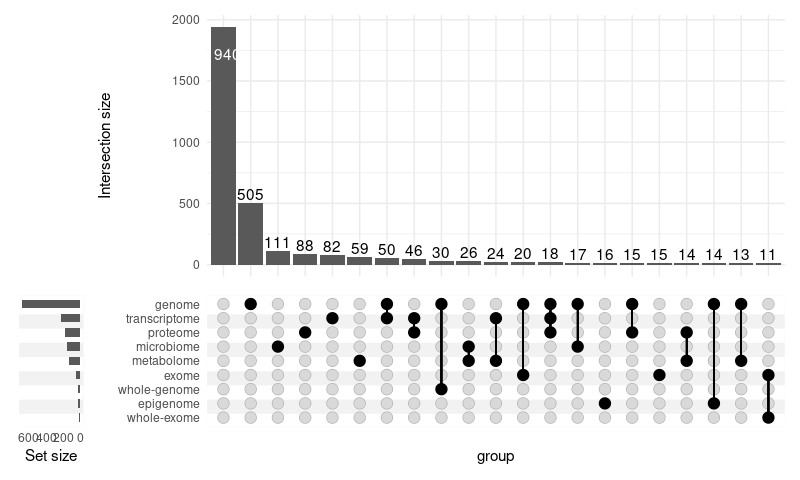

In [39]:
%%R -i ome_terms_mentioned -w 800 -r 100

upset(ome_terms_mentioned, colnames(ome_terms_mentioned), min_size=10, width_ratio=0.1)

[1] "Dropping 14 empty groups"


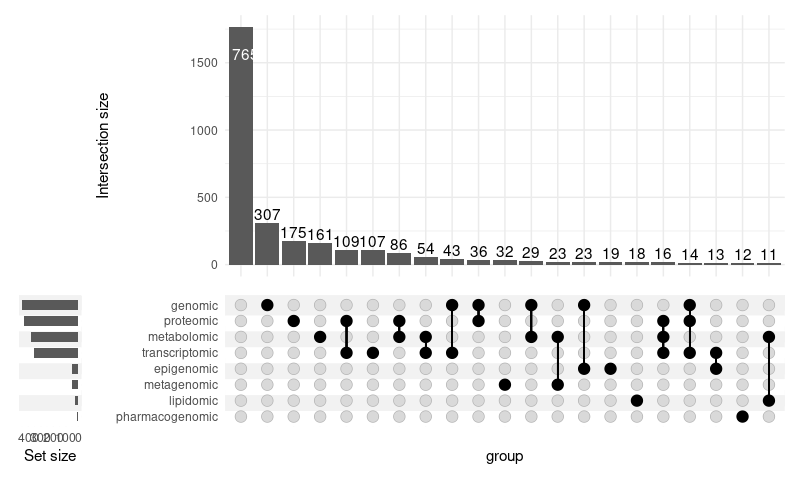

In [40]:
%%R -i omic_terms_mentioned -w 800 -r 100

upset(omic_terms_mentioned, colnames(omic_terms_mentioned), min_size=10, width_ratio=0.1)

## Merge -ome and -omic terms

In [41]:
terms_to_omics = {
    'whole-transcriptome': 'transcriptomics',
    'whole-genome': 'genomics',
    # note: some researchers use "exomics", but it is relatively rare and
    # does not occur on its own in analysed papers, thus using "genomics"
    'exome': 'genomics',
    'whole-exome': 'genomics',
}

In [42]:
from warnings import warn

terms_associated_with_omic = {
    omic + 's': [omic]
    for omic in omic_terms
}

for ome in ome_terms:
    assert ome.endswith('ome')
    auto_generate_omic_term = ome[:-3] + 'omics'
    omic = terms_to_omics.get(
        ome,
        auto_generate_omic_term  # default if no custom
    )
    if omic not in terms_associated_with_omic:
        if omic in omic_counts.index:
            warn(f'{omic} was removed at thresholding, but it is a frequent -ome!')
        else:
            print(f'Creating omic {omic}')
        terms_associated_with_omic[omic] = []

    terms_associated_with_omic[omic].append(ome)

terms_associated_with_omic

Creating omic interactomics
Creating omic secretomics
Creating omic translatomics
Creating omic exposomics
Creating omic mirnomics


{'proteomics': ['proteomic', 'proteome'],
 'genomics': ['genomic', 'genome', 'exome', 'whole-genome', 'whole-exome'],
 'metabolomics': ['metabolomic', 'metabolome'],
 'transcriptomics': ['transcriptomic', 'transcriptome', 'whole-transcriptome'],
 'metagenomics': ['metagenomic', 'metagenome'],
 'epigenomics': ['epigenomic', 'epigenome'],
 'lipidomics': ['lipidomic', 'lipidome'],
 'proteogenomics': ['proteogenomic'],
 'phosphoproteomics': ['phosphoproteomic', 'phosphoproteome'],
 'metaproteomics': ['metaproteomic'],
 'pharmacogenomics': ['pharmacogenomic'],
 'metatranscriptomics': ['metatranscriptomic', 'metatranscriptome'],
 'phenomics': ['phenomic', 'phenome'],
 'glycomics': ['glycomic'],
 'fluxomics': ['fluxomic'],
 'radiomics': ['radiomic'],
 'meta-omics': ['meta-omic'],
 'metabonomics': ['metabonomic'],
 'peptidomics': ['peptidomic'],
 'methylomics': ['methylomic', 'methylome'],
 'nutrigenomics': ['nutrigenomic'],
 'microbiomics': ['microbiomic', 'microbiome'],
 'interactomics': ['i